### Importing the Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np 

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet

In [6]:
#Reading the dataset 
df=pd.read_excel('CreditCardCustomerDataSet.xlsx')
df.shape

(660, 7)

In [7]:
#Viewing few records
df

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


In [8]:
df['Customer Key'].drop_duplicates(keep='last').shape

(655,)

In [9]:
df['Customer Key'].value_counts()

97935    2
50706    2
47437    2
37252    2
96929    2
        ..
73811    1
72892    1
51773    1
96163    1
80150    1
Name: Customer Key, Length: 655, dtype: int64

In [10]:
df[df['Customer Key']==50706]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


In [11]:
# Dropping duplicates based on unique customer key
df = df.iloc[df['Customer Key'].drop_duplicates(keep='last').index]
df.shape

(655, 7)

The cols : Sl_No and CustomerKey are IDs which can be eliminated as they are unique and will not have any relevant role in forming the clusters so we remove them

In [12]:
cols_to_consider=['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

In [13]:
subset=df[cols_to_consider]  #Selecting only the above columns 

In [14]:
subset

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
5,20000,3,0,1,8
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


### EDA 

#### Checking for Missing Values 

In [15]:
subset.isna().sum() 

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No missing values were found 

#### Checking for the statistically summary 

In [16]:
subset.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.00000,655.000000,655.000000,655.000000
mean,34563.358779,4.71145,2.404580,2.601527,3.575573
std,37648.200947,2.17241,1.625385,2.920192,2.855867
min,3000.000000,1.00000,0.000000,0.000000,0.000000
25%,10000.000000,3.00000,1.000000,1.000000,1.000000
50%,18000.000000,5.00000,2.000000,2.000000,3.000000
75%,48000.000000,6.00000,4.000000,4.000000,5.000000
max,200000.000000,10.00000,5.000000,15.000000,10.000000


The min and max value of 'Avg_Credit_Limit' is very larger as compared to the other columns 
To bring the data to the same scale let's standardize the data.



## Feature Correlations

In [17]:
# Use Corr function to create correlation matrix
subset.corr()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608845,-0.099033,0.548840,-0.415595
Total_Credit_Cards,0.608845,1.000000,0.319349,0.165271,-0.652674
Total_visits_bank,-0.099033,0.319349,1.000000,-0.550358,-0.503173
Total_visits_online,0.548840,0.165271,-0.550358,1.000000,0.129117
Total_calls_made,-0.415595,-0.652674,-0.503173,0.129117,1.000000


**Plot Correlation Matrix**

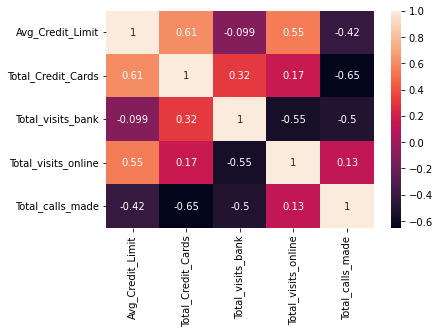

In [18]:
## Use Seaborn Heatmap to visualize correlation matrix
sns.heatmap(subset.corr(),annot=True);

## Visualize feature distributions

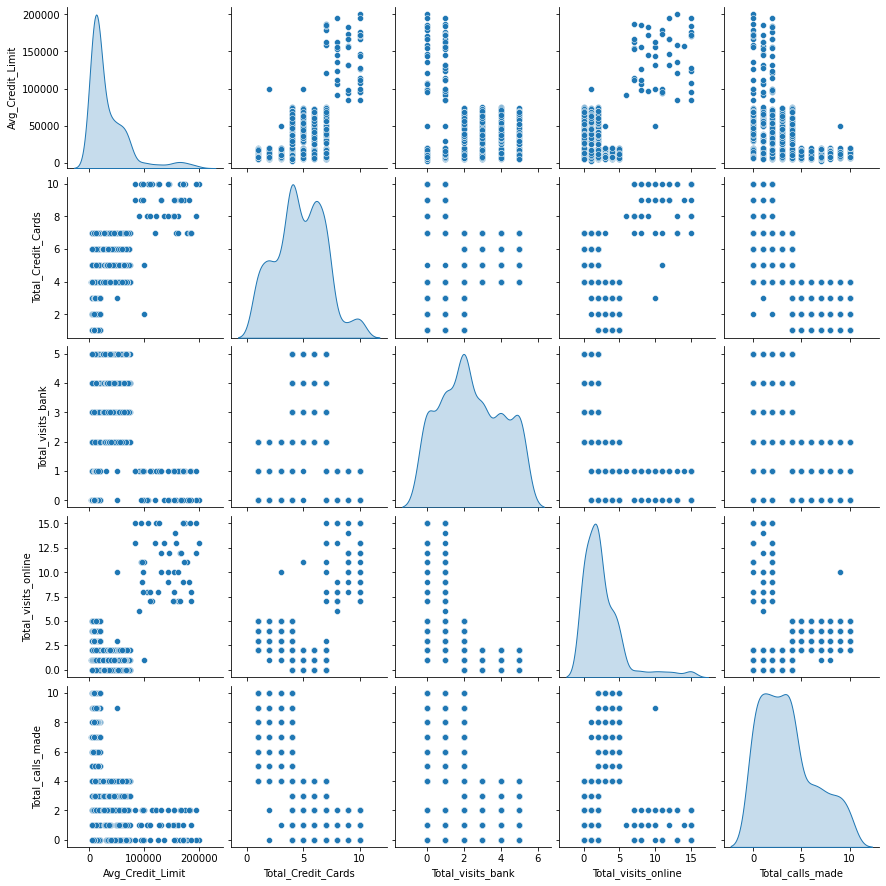

In [19]:
sns.pairplot(subset,diag_kind='kde');

## Check Skewness

In [20]:
subset.skew()

Avg_Credit_Limit       2.209182
Total_Credit_Cards     0.140402
Total_visits_bank      0.140206
Total_visits_online    2.234473
Total_calls_made       0.658983
dtype: float64

### Log Transformation (Box cox transormation)

In [21]:
subset_2=subset.copy()

In [22]:
# Use Log transformation to scale features
## Hint : use np.log function 
subset_2['Avg_Credit_Limit'] = np.log(subset_2['Avg_Credit_Limit']+0.1) #can't take log(0) and so add a small number
subset_2['Total_visits_online'] = np.log(subset_2['Total_visits_online']+0.1)

In [23]:
subset_2.skew()

Avg_Credit_Limit       0.395124
Total_Credit_Cards     0.140402
Total_visits_bank      0.140206
Total_visits_online   -0.780595
Total_calls_made       0.658983
dtype: float64

## Visualize the Normalized data

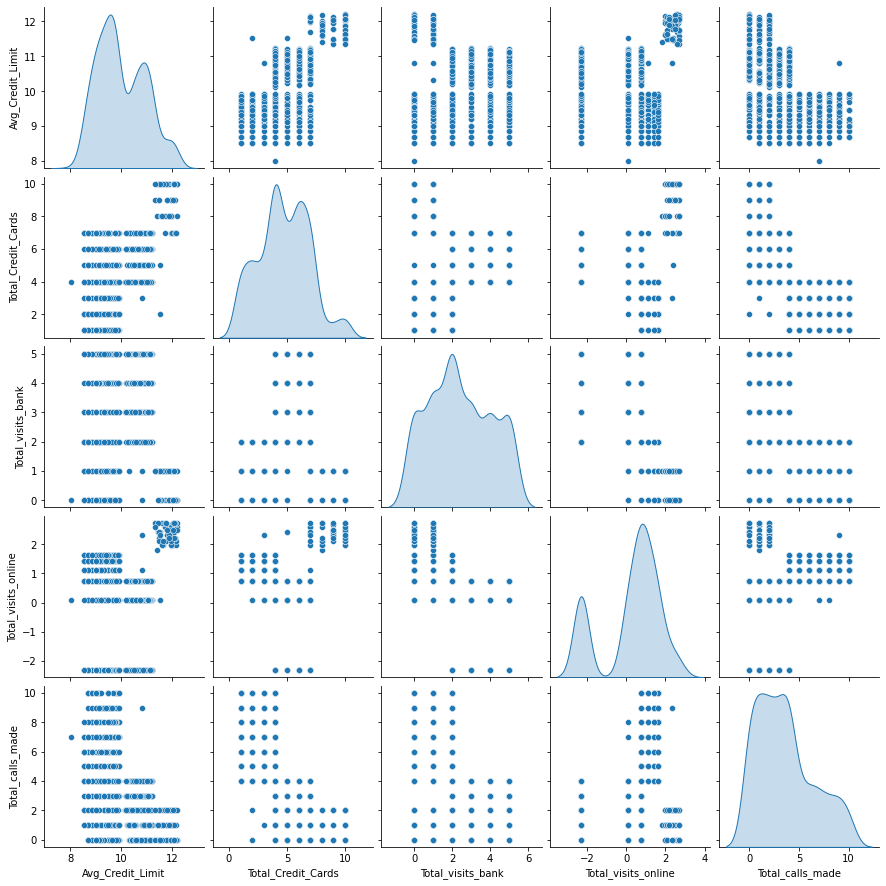

In [24]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(subset_2,diag_kind='kde');

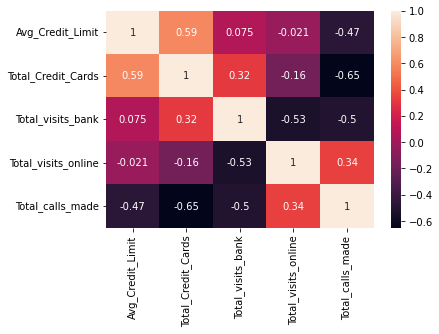

In [25]:
sns.heatmap(subset_2.corr(),annot=True);

##  Feature Scaling For Standardization -  Standard Scaler ( Z Score )

In [26]:
scaler=StandardScaler()
subset_scaled=scaler.fit_transform(subset_2)   

In [27]:
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset_2.columns)   #Creating a dataframe of the above results

In [28]:
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.631393,-1.249084,-0.864813,-0.116601,-1.252966
1,0.885986,-0.788414,-1.480522,1.384619,1.900849
2,0.885986,1.054266,-0.864813,0.584907,0.148730
3,0.336647,0.132926,-0.864813,-0.116601,0.148730
4,-0.099387,-0.788414,-1.480522,-0.116601,1.550425
...,...,...,...,...,...
650,1.620585,2.436277,-0.864813,1.384619,-1.252966
651,1.443894,2.436277,-0.864813,1.560710,-0.552118
652,2.030971,1.514937,-0.864813,1.314027,-0.902542
653,2.214607,2.436277,-0.864813,1.656910,-1.252966


In [29]:
subset_scaled_df.skew()

Avg_Credit_Limit       0.395124
Total_Credit_Cards     0.140402
Total_visits_bank      0.140206
Total_visits_online   -0.780595
Total_calls_made       0.658983
dtype: float64

## Execute K-Means Algorithm

In [30]:
## Iterate the K-Means for different values of clusters. Compute the error term and store in an object

cluster_range = range( 1, 15)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 100,init='k-means++')
    clusters.fit(subset_scaled_df)
    cluster_errors.append( clusters.inertia_ )    # capture the intertia

In [31]:
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df

,num_clusters,cluster_errors
0,1,3275.000000
1,2,1853.800771
2,3,1301.962481
3,4,990.628920
4,5,851.602617
5,6,761.210485
6,7,683.311795
7,8,628.154096
8,9,594.553271
9,10,562.428203


## Elbow Method

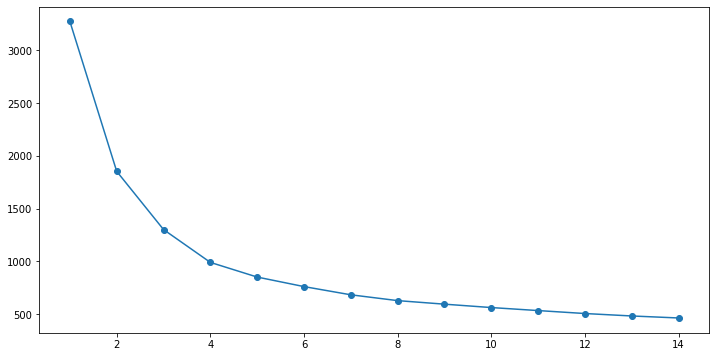

In [32]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );

## Execute the K-Means again with optimal cluster number 

In [33]:
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [34]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.73467595, -1.05048414, -0.89217777,  0.6535984 ,  1.13147403],
       [ 1.93851753,  1.84914816, -1.08212205,  1.37886929, -0.86131593],
       [ 0.17529735,  0.37480838,  0.67527236, -0.57356721, -0.55581674]])

In [35]:
centroid_df = pd.DataFrame(centroids, columns = subset_scaled_df.columns )

In [36]:
centroid_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.734676,-1.050484,-0.892178,0.653598,1.131474
1,1.938518,1.849148,-1.082122,1.378869,-0.861316
2,0.175297,0.374808,0.675272,-0.573567,-0.555817


The above are the centroids for the different clusters 

#### Adding Label to the dataset

In [37]:
dataset=subset_scaled_df[:]  #creating a copy of the data 

In [38]:
dataset['KmeansLabel']=kmeans.labels_

In [39]:
dataset.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,1.631393,-1.249084,-0.864813,-0.116601,-1.252966,2
1,0.885986,-0.788414,-1.480522,1.384619,1.900849,0
2,0.885986,1.054266,-0.864813,0.584907,0.148730,1
3,0.336647,0.132926,-0.864813,-0.116601,0.148730,2
4,-0.099387,-0.788414,-1.480522,-0.116601,1.550425,0
5,1.631393,0.132926,-1.480522,1.448541,-0.552118,1
6,-0.408758,-0.788414,-1.480522,-0.116601,-0.902542,0
7,-1.590188,-1.249084,-1.480522,0.321212,-0.552118,0
8,-2.139514,-0.327744,-1.480522,-0.116601,1.200001,0
9,-0.844791,-0.327744,-1.480522,0.921980,0.499153,0


In [40]:
dataset.groupby('KmeansLabel').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0,-0.734676,-1.050484,-0.892178,0.653598,1.131474
1,1.938518,1.849148,-1.082122,1.378869,-0.861316
2,0.175297,0.374808,0.675272,-0.573567,-0.555817


## Customer Profiling - Visualizing the clusters

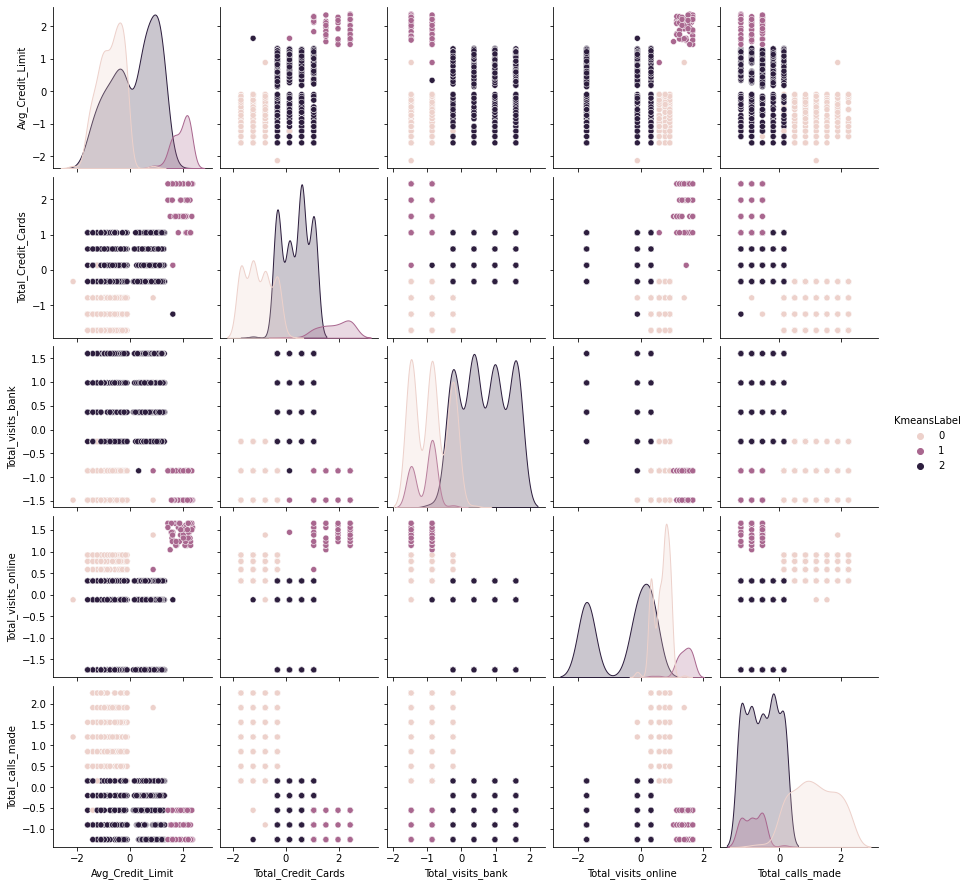

In [41]:
sns.pairplot(dataset,diag_kind='kde',hue='KmeansLabel');

In [42]:
subset['KmeansLabel']=kmeans.labels_
subset

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,100000,2,1,1,0,2
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,2
5,20000,3,0,1,8,0
...,...,...,...,...,...,...
655,99000,10,1,10,0,1
656,84000,10,1,13,2,1
657,145000,8,1,9,1,1
658,172000,10,1,15,0,1


In [43]:
subset.groupby('KmeansLabel').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0,12111.111111,2.431111,0.955556,3.546667,6.804444
1,138647.058824,8.725490,0.647059,10.549020,1.117647
2,33886.543536,5.525066,3.501319,0.970976,1.989446


### Analyse the Clusters 

Let us make a visualization to observe the different clusters by making boxplots , 
for the clusters we expect to observe statistical properties which differentiates clusters with each other 

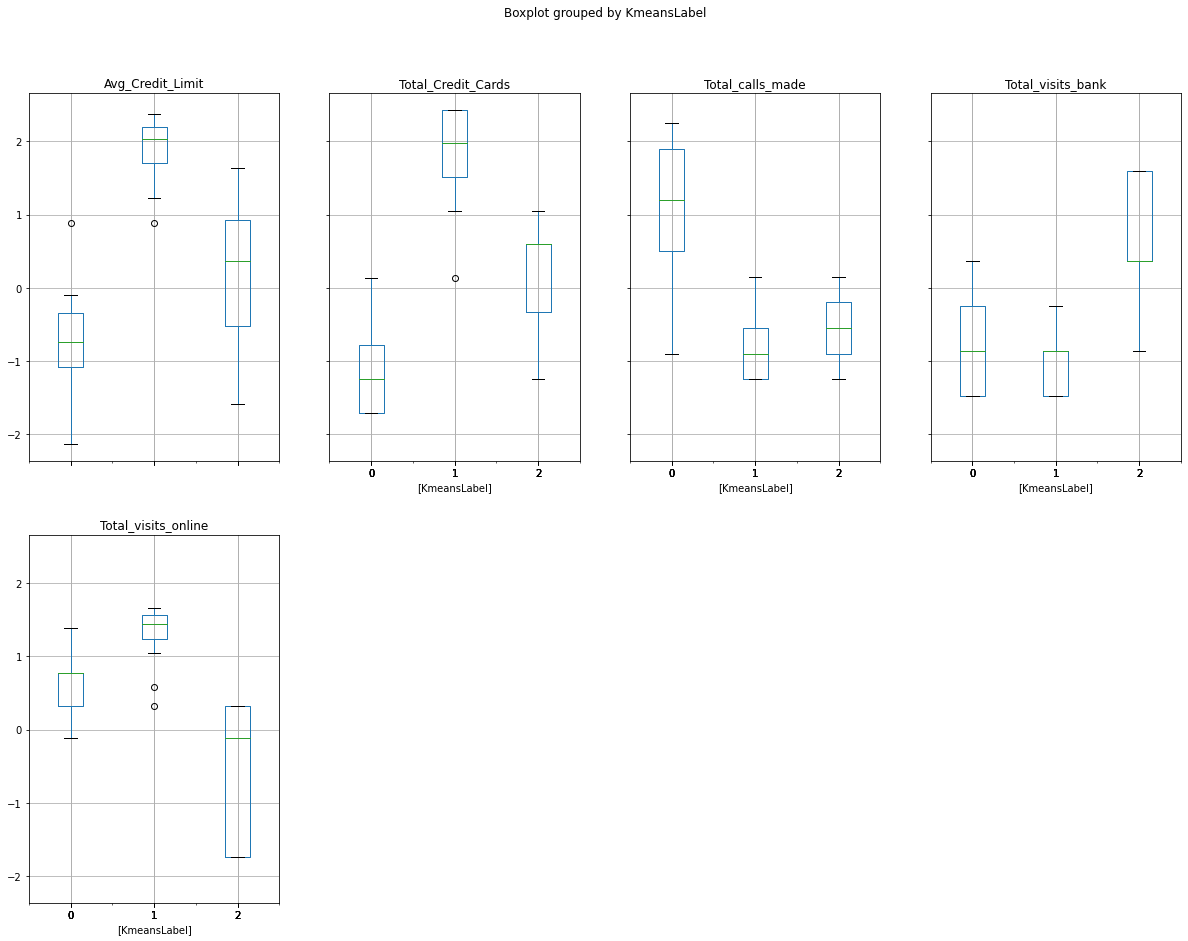

In [44]:
dataset.boxplot(by = 'KmeansLabel',  layout=(2,4), figsize=(20, 15))
plt.show()

Looking the box plot we can observe differentiated clusters 

## Silhoutte Analysis For K-Means Clustering

In [45]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

Automatically created module for IPython interactive environment


In [46]:
dataset

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,1.631393,-1.249084,-0.864813,-0.116601,-1.252966,2
1,0.885986,-0.788414,-1.480522,1.384619,1.900849,0
2,0.885986,1.054266,-0.864813,0.584907,0.148730,1
3,0.336647,0.132926,-0.864813,-0.116601,0.148730,2
4,-0.099387,-0.788414,-1.480522,-0.116601,1.550425,0
...,...,...,...,...,...,...
650,1.620585,2.436277,-0.864813,1.384619,-1.252966,1
651,1.443894,2.436277,-0.864813,1.560710,-0.552118,1
652,2.030971,1.514937,-0.864813,1.314027,-0.902542,1
653,2.214607,2.436277,-0.864813,1.656910,-1.252966,1


For n_clusters = 2 The average silhouette_score is : 0.407755051926829


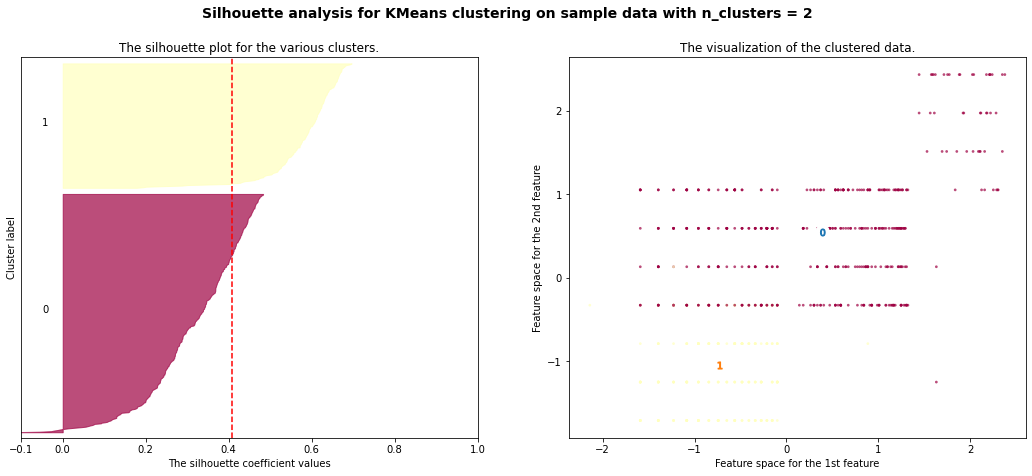

For n_clusters = 3 The average silhouette_score is : 0.4475086174035754


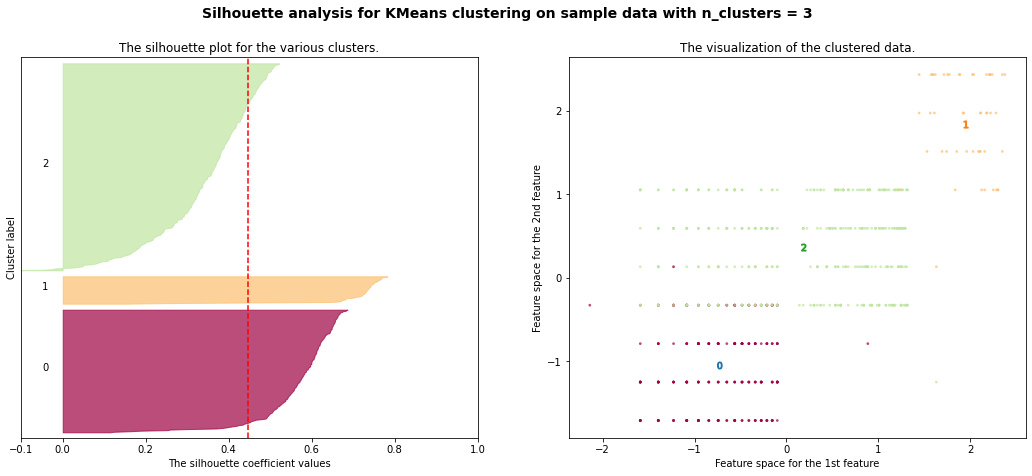

For n_clusters = 4 The average silhouette_score is : 0.41358421611582763


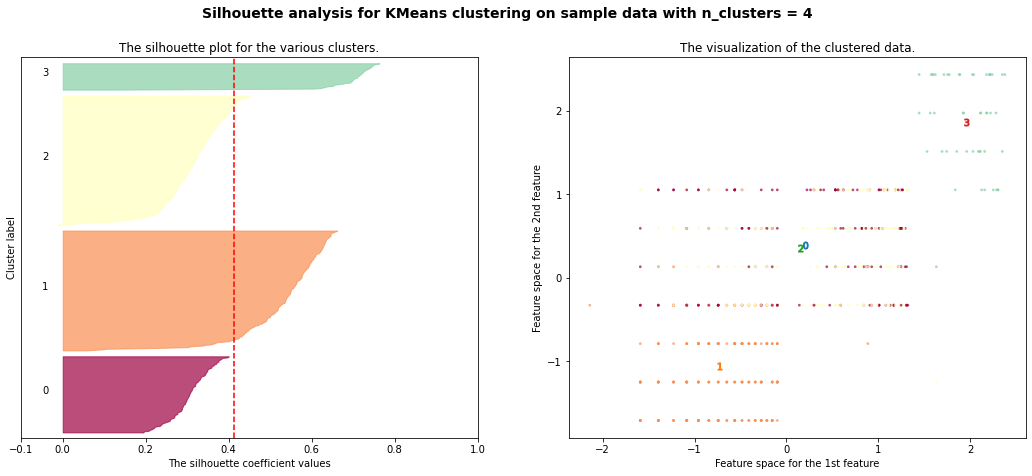

For n_clusters = 5 The average silhouette_score is : 0.3791938614637877


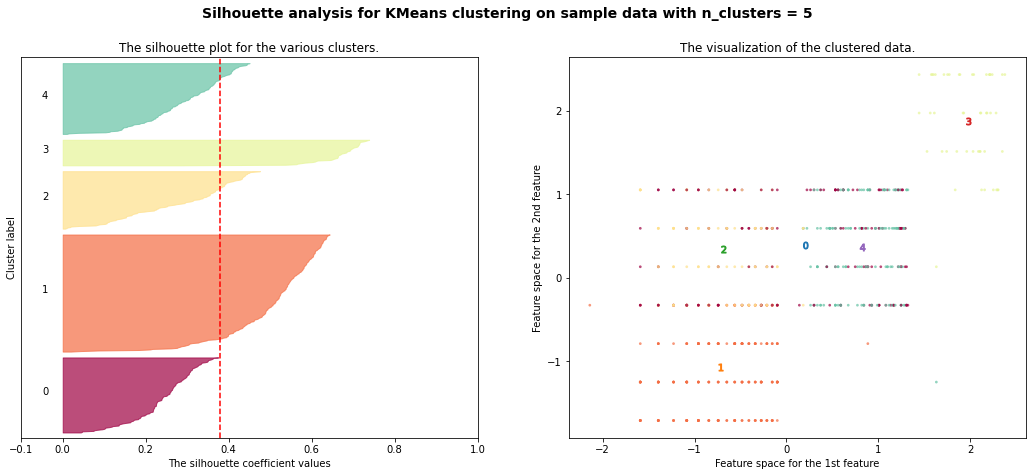

For n_clusters = 6 The average silhouette_score is : 0.38897213460787733


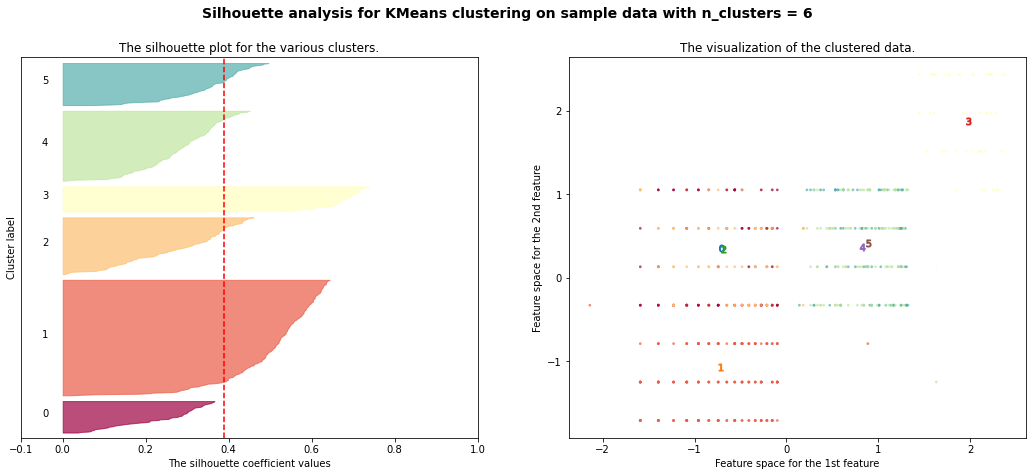

For n_clusters = 7 The average silhouette_score is : 0.299875379012079


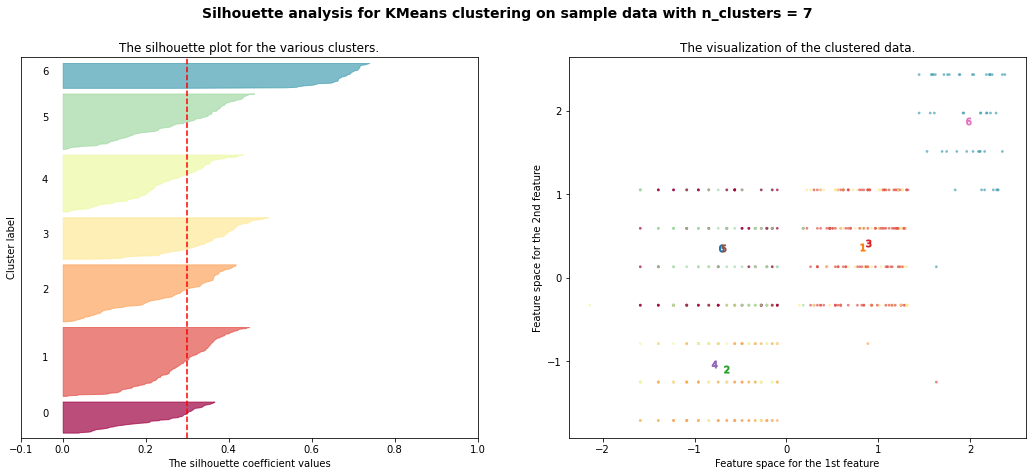

For n_clusters = 8 The average silhouette_score is : 0.2865810048424564


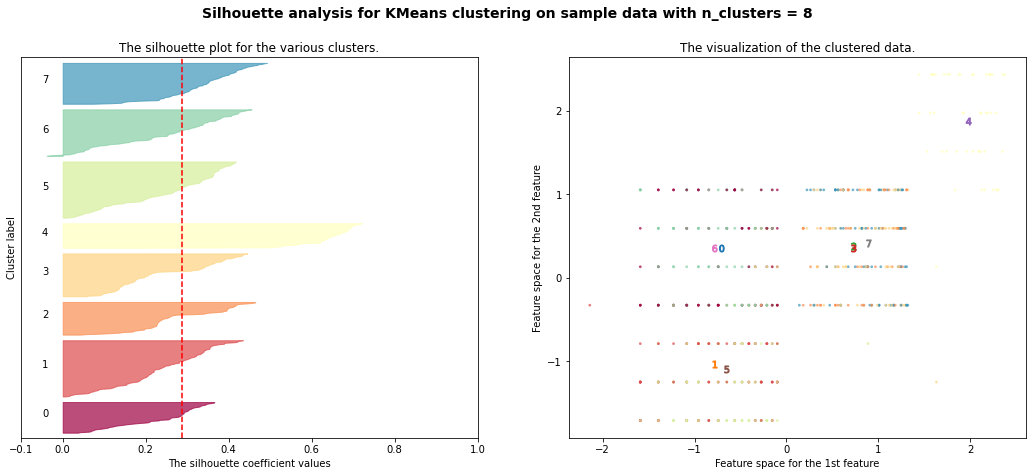

For n_clusters = 9 The average silhouette_score is : 0.28708161175522423


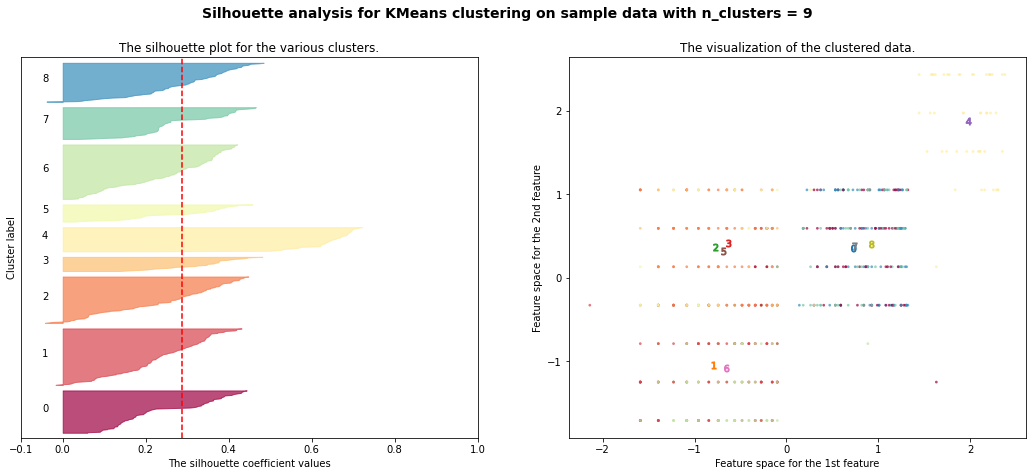

For n_clusters = 10 The average silhouette_score is : 0.28281079628284067


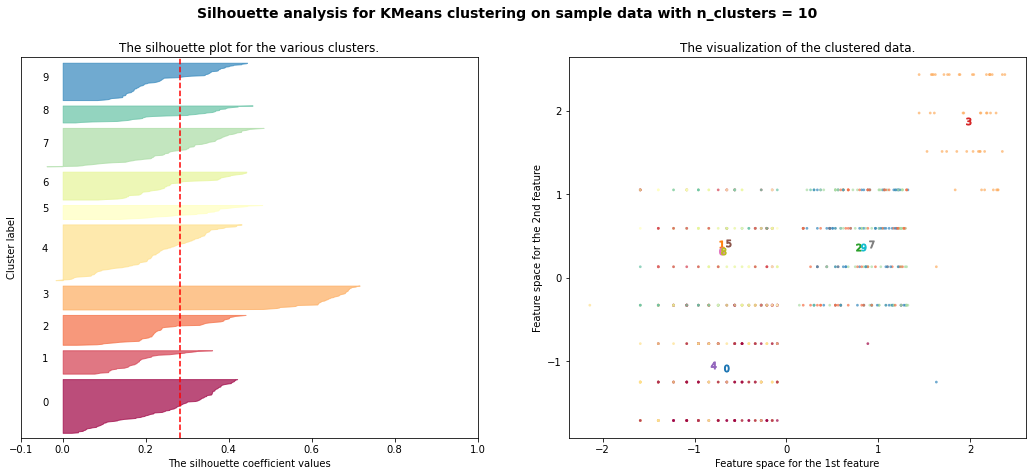

In [47]:
X=dataset.drop('KmeansLabel',axis=1).values
y=dataset['KmeansLabel'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# <center> Hierarchical Clustering 

Now that we have tried Kmeans , let's try hierarchical clustering with different dendograms for the same dataset and choosing the best using the cophenetic coefficient by using different types of linkages

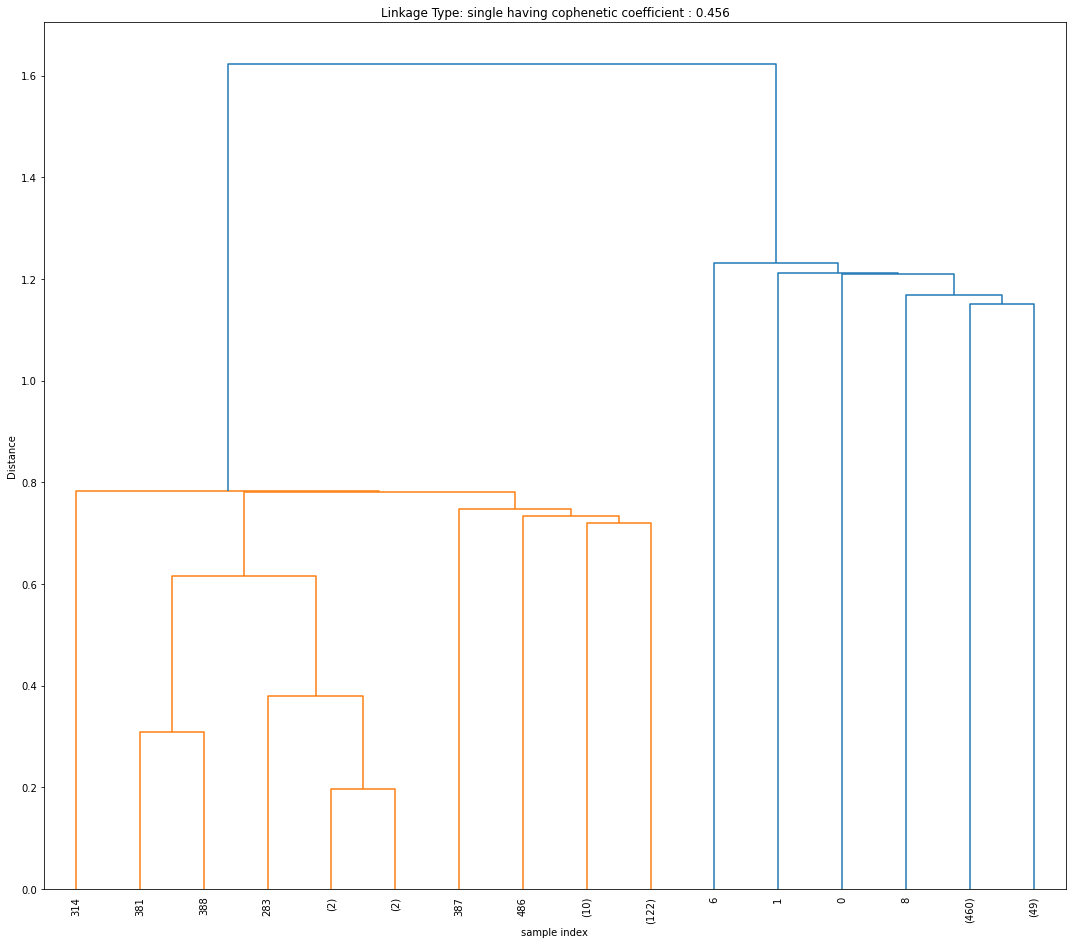

single 0.45600470872039245


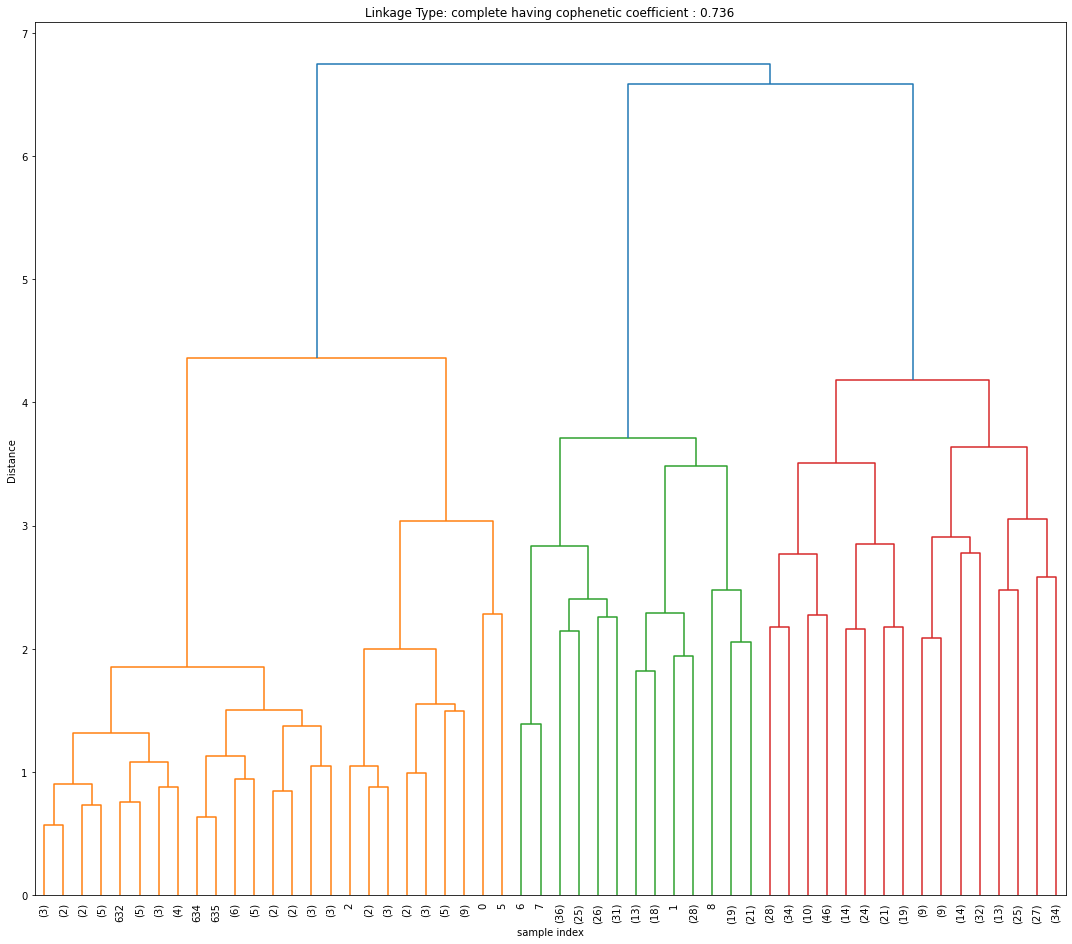

complete 0.736241455097867


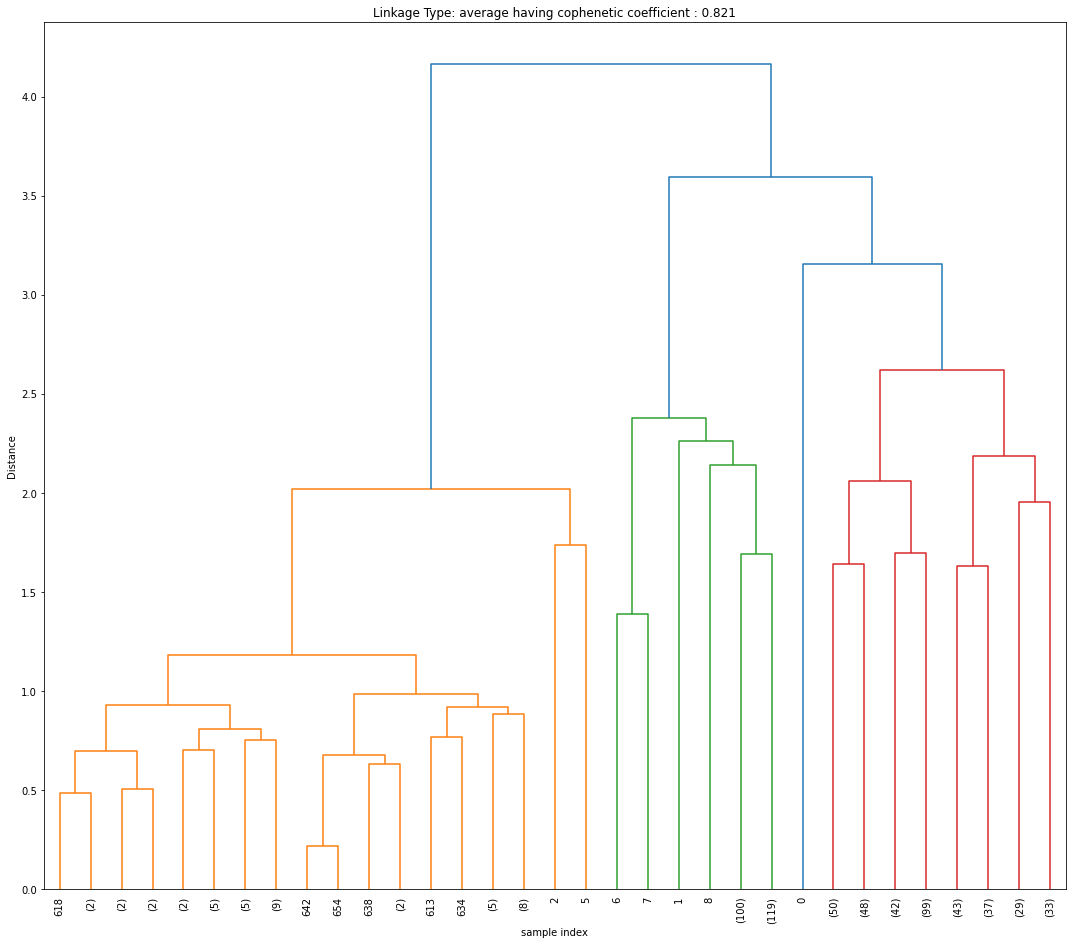

average 0.8208631405564834


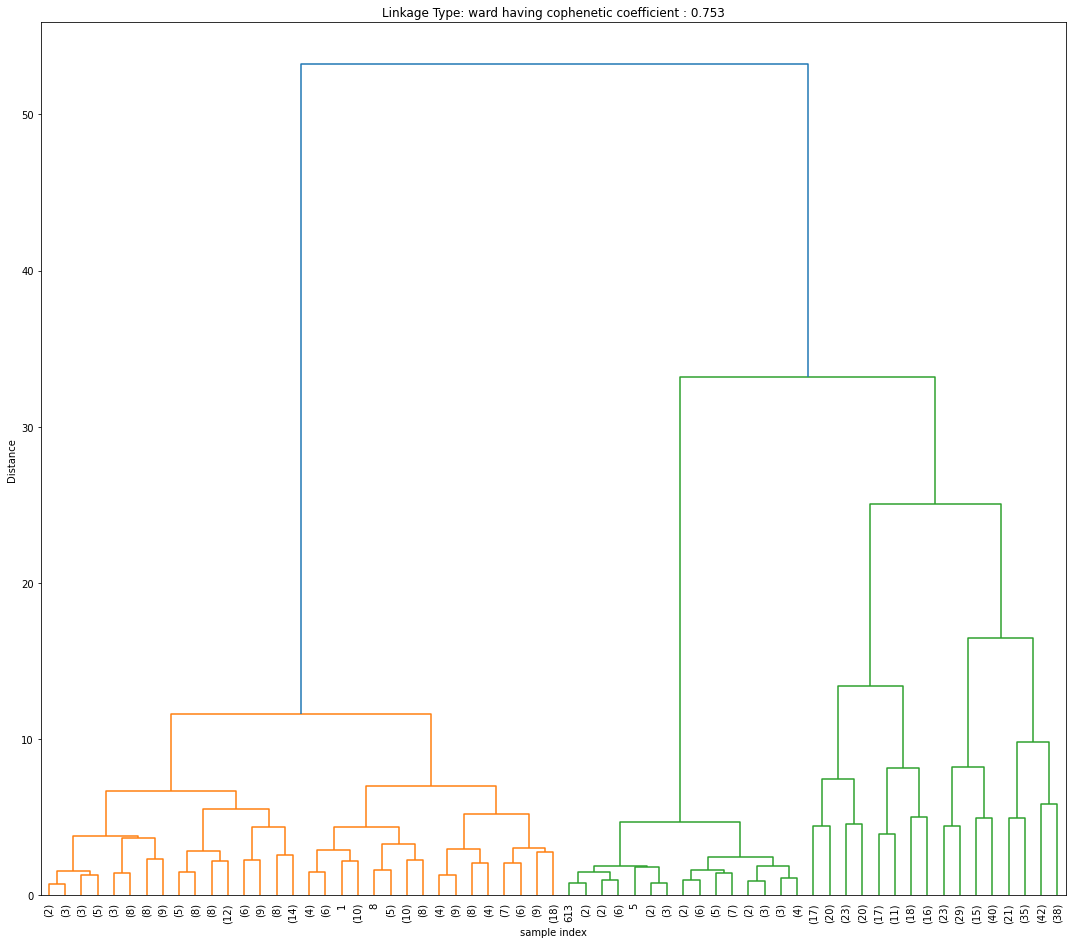

ward 0.753066363619644


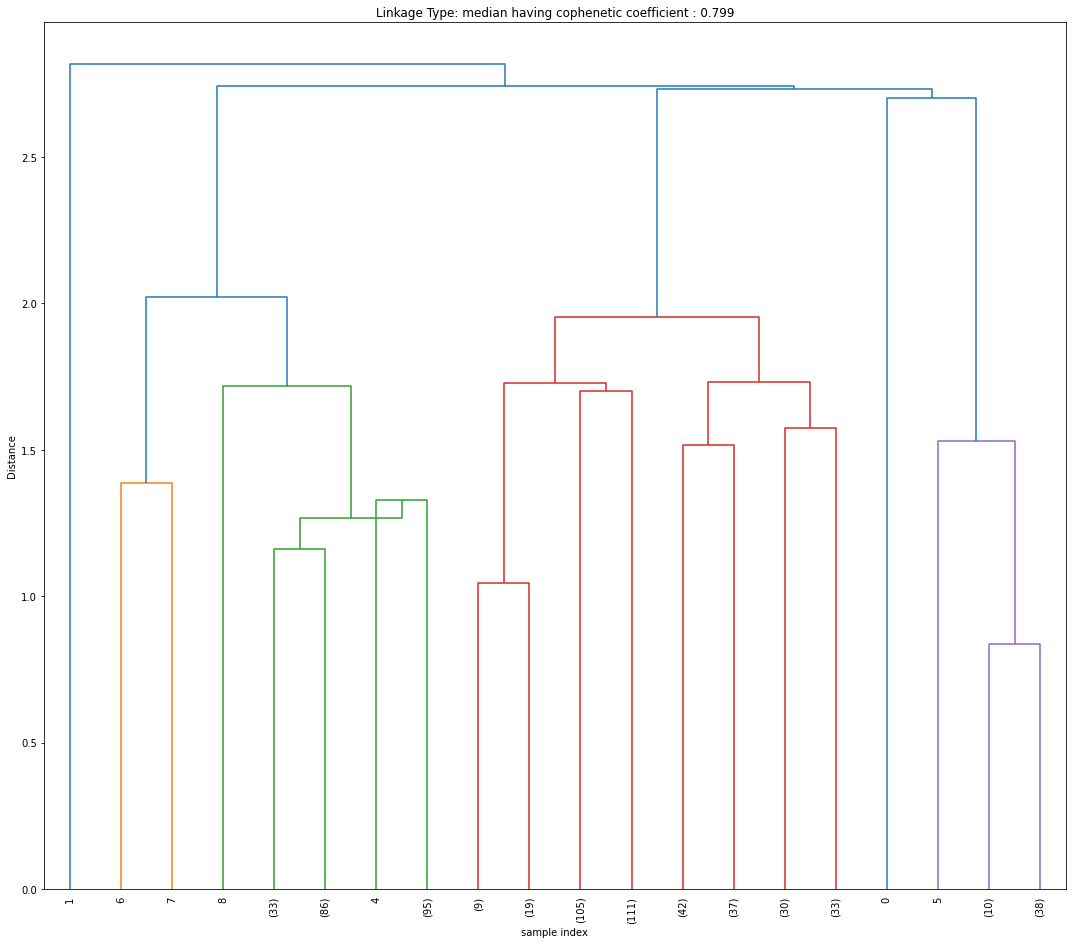

median 0.7987795803761116


In [48]:
linkage_methods=['single','complete','average','ward','median']
results_cophenetic_coef=[]
for i in linkage_methods :
    plt.figure(figsize=(15, 13))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    Z = linkage(subset_scaled_df, i)
    cc,cophn_dist=cophenet(Z,pdist(subset_scaled_df))
    dendrogram(Z,leaf_rotation=90.0,p=5,leaf_font_size=10,truncate_mode='level')
    plt.tight_layout()
    plt.title("Linkage Type: "+ i +" having cophenetic coefficient : "+str(round(cc,3)) )
    plt.show()
    results_cophenetic_coef.append((i,cc))
    print (i,cc)

In [49]:
results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','CopheneticCoefficient'])
results_cophenetic_coef_df

,LinkageMethod,CopheneticCoefficient
0,single,0.456005
1,complete,0.736241
2,average,0.820863
3,ward,0.753066
4,median,0.798780


Looking at the best cophenetic coefficient we get is for "Average" linkage.

But looking at dendogram 'ward' and 'complete' show good difference between clusters.

So choosing 'complete' because it has high cophenetic coefficirnt and good cluster segregation.

Lets make a dendogram for the last 25 formed clusters using complete linkage to have a better view since the above dendograms are very populated 

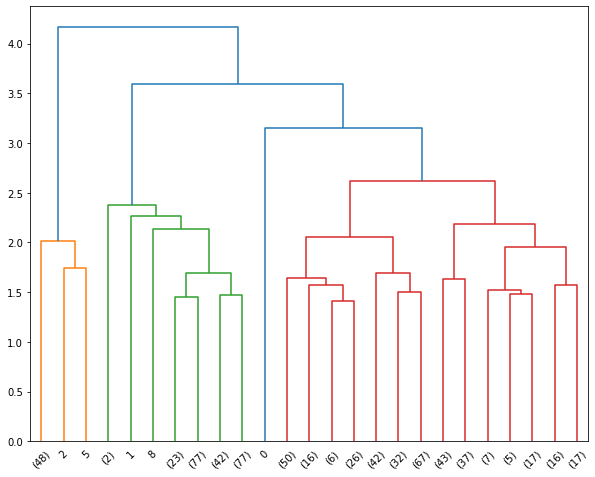

In [50]:
#use truncate_mode='lastp' to select last p formed clusters
plt.figure(figsize=(10,8))
Z = linkage(subset_scaled_df, 'average', metric='euclidean')

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25 # show only the last p merged clusters
)
plt.show()

Let's take a maximum distance around 5 to form the different clusters as clearly visible it cuts the tallest vertical lines.

In [51]:
max_d=3.2
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')

In [52]:
set(clusters)  # So there are 3 clusters which are formed 

{1, 2, 3}

### Assign the clusters label to the  data set

In [53]:
dataset2=subset_scaled_df[:] #Create a duplicate of the dataset

In [54]:
dataset2['HierarchicalClusteringLabel']=clusters

In [55]:
dataset2

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HierarchicalClusteringLabel
0,1.631393,-1.249084,-0.864813,-0.116601,-1.252966,3
1,0.885986,-0.788414,-1.480522,1.384619,1.900849,2
2,0.885986,1.054266,-0.864813,0.584907,0.148730,1
3,0.336647,0.132926,-0.864813,-0.116601,0.148730,3
4,-0.099387,-0.788414,-1.480522,-0.116601,1.550425,2
...,...,...,...,...,...,...
650,1.620585,2.436277,-0.864813,1.384619,-1.252966,1
651,1.443894,2.436277,-0.864813,1.560710,-0.552118,1
652,2.030971,1.514937,-0.864813,1.314027,-0.902542,1
653,2.214607,2.436277,-0.864813,1.656910,-1.252966,1


### Analyse the clusters 

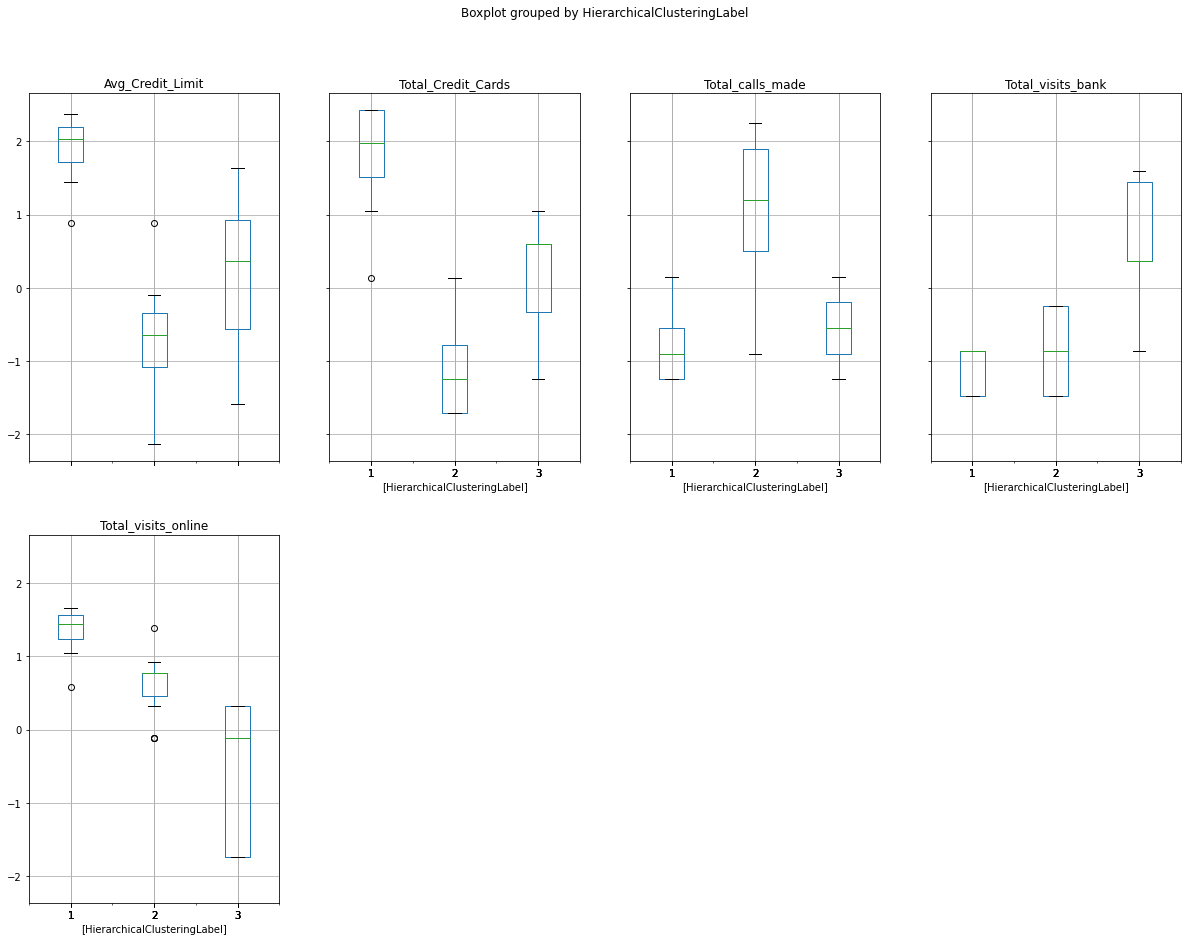

In [56]:
dataset2.boxplot(by = 'HierarchicalClusteringLabel',  layout=(2,4), figsize=(20, 15))
plt.show()

Here also we observe differentiated clusters.

### Silhouette Score

In [57]:
from sklearn.metrics import silhouette_score
silhouette_score(dataset.drop('KmeansLabel',axis=1),dataset['KmeansLabel'])

0.4475086174035754

In [58]:
from sklearn.metrics import silhouette_score
silhouette_score(dataset2.drop('HierarchicalClusteringLabel',axis=1),dataset2['HierarchicalClusteringLabel'])

0.448781458338738

Silhouette Score is better when closer 1 and worse when closer to -1

Here Kmeans score is slightly better tha Hierarchical

### Comparing Kmeans and Hierarchical Results

In [59]:
Kmeans_results=dataset.groupby('KmeansLabel').mean()
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0,-0.734676,-1.050484,-0.892178,0.653598,1.131474
1,1.938518,1.849148,-1.082122,1.378869,-0.861316
2,0.175297,0.374808,0.675272,-0.573567,-0.555817


In [60]:
dataset.groupby('KmeansLabel').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0,225,225,225,225,225
1,51,51,51,51,51
2,379,379,379,379,379


In [61]:
Hierarchical_results=dataset2.groupby('HierarchicalClusteringLabel').mean()
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HierarchicalClusteringLabel,,,,,
1,1.952641,1.865046,-1.098782,1.400022,-0.867500
2,-0.730149,-1.056966,-0.900706,0.656579,1.143431
3,0.170658,0.372909,0.669625,-0.566540,-0.553953


In [62]:
dataset2.groupby('HierarchicalClusteringLabel').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HierarchicalClusteringLabel,,,,,
1,50,50,50,50,50
2,223,223,223,223,223
3,382,382,382,382,382


#### Carefully observing the above results we can say that : 



Cluster 0 of Kmeans appears similar to Cluster 2 of Hierarchical 


Cluster 1 of Kmeans appears similar to Cluster 3 of Hierarchical 


Cluster 2 of Kmeans appears similar to Cluster 1 of Hierarchical 



#### Let's rename 


Cluster 0 of Kmeans  and Cluster 2 of Hierarchical as G1

Cluster 1 of Kmeans  and Cluster 3 of Hierarchical as G2

Cluster 2 of Kmeans  and Cluster 1 of Hierarchical as G3



In [63]:
Kmeans_results.index=['G1','G2','G3']
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
G1,-0.734676,-1.050484,-0.892178,0.653598,1.131474
G2,1.938518,1.849148,-1.082122,1.378869,-0.861316
G3,0.175297,0.374808,0.675272,-0.573567,-0.555817


In [64]:
Hierarchical_results.index=['G3','G1','G2']
Hierarchical_results.sort_index(inplace=True)
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
G1,-0.730149,-1.056966,-0.900706,0.656579,1.143431
G2,0.170658,0.372909,0.669625,-0.566540,-0.553953
G3,1.952641,1.865046,-1.098782,1.400022,-0.867500


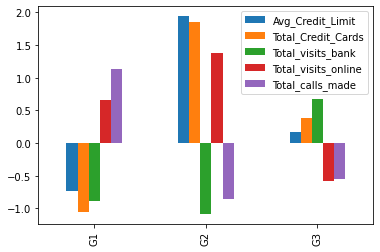

In [65]:
Kmeans_results.plot.bar();

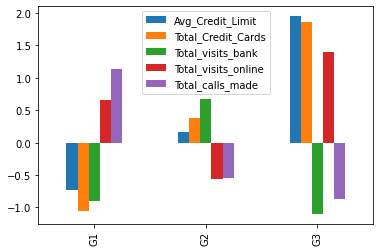

In [66]:
Hierarchical_results.plot.bar();

#### By both the methods of Clustering we get comparable clusters

## Cluster Profiles and Marketing Recommendation

Since both the clustering alogrithms are giving similar clusters so we can assign labels from any one of the algorithm to the original (non scaled) data  to analyse clusters profiles
( here we are assigning labels of Kmeans , same could be done using hierarchical labels) 

In [67]:
subset['KmeansLabel']=dataset['KmeansLabel']


In [68]:
subset

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,100000,2,1,1,0,2.0
1,50000,3,0,10,9,0.0
2,50000,7,1,3,4,1.0
3,30000,5,1,1,4,2.0
5,20000,3,0,1,8,1.0
...,...,...,...,...,...,...
655,99000,10,1,10,0,NaN
656,84000,10,1,13,2,NaN
657,145000,8,1,9,1,NaN
658,172000,10,1,15,0,NaN


In [69]:
subset.groupby('KmeansLabel').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0.0,12563.063063,2.454955,0.981982,3.581081,6.738739
1.0,127647.058824,8.313725,0.901961,9.274510,1.235294
2.0,33615.384615,5.490716,3.466844,1.000000,2.063660


#### Understanding each feature characterstics within different clusters 

In [70]:
for each in cols_to_consider:
    print (each)
    print ( subset.groupby('KmeansLabel').describe().round()[each][['count','mean','min','max']])
    
    print ("\n\n")
    
    

Avg_Credit_Limit
             count      mean      min       max
KmeansLabel                                    
0.0          222.0   12563.0   3000.0  100000.0
1.0           51.0  127647.0  20000.0  200000.0
2.0          377.0   33615.0   5000.0  100000.0



Total_Credit_Cards
             count  mean  min   max
KmeansLabel                        
0.0          222.0   2.0  1.0   6.0
1.0           51.0   8.0  3.0  10.0
2.0          377.0   5.0  1.0   7.0



Total_visits_bank
             count  mean  min  max
KmeansLabel                       
0.0          222.0   1.0  0.0  5.0
1.0           51.0   1.0  0.0  4.0
2.0          377.0   3.0  1.0  5.0



Total_visits_online
             count  mean  min   max
KmeansLabel                        
0.0          222.0   4.0  0.0  11.0
1.0           51.0   9.0  0.0  15.0
2.0          377.0   1.0  0.0   4.0



Total_calls_made
             count  mean  min   max
KmeansLabel                        
0.0          222.0   7.0  0.0  10.0
1.0           

### Analysis of clusters and questions answered :
    

#### 1. How many different segments of customers are there? 

Answer : Total numbers of segments are 3
    
    
  

#### 2. How are these segments different from each other? (Cluster profiles )
  

Answer: 
    

**Label 0 can be considered low valued customers**
   
    This group comprises of about 34% of the customers ( 224/660 )
    
    These customers have a mean "Avg_Credit_Limit " around 12200 and have 2 credit card on an average and the maximum number of credit card as 4.
    
    They are the ones who makes the most number of customer care calls to the bank as the average calls made is 7 



**Label 1 can be considered medium valued customers** 
    
    This group forms the majority of the customers having about 58% customers in total  ( 386/660 )
    
    These customers have  "Avg_Credit_Limit " ranging from 5000.0 to 100000.0 
    
    These are the ones which make the maximum number of visits to the bank as the average visits to bank is 3.
    
    They are the ones who are least active online as the maximum visit onine is just 3



**Label 2 can be considered  high value customers** 
    
    These are the least in number i.e. only 50 customers comprising 7.5% of total customers (50/660) .
    
    These customers have a minimum "Avg_Credit_Limit " of 84000 and have atleast 5 Credit cards .
    
    These are the ones which make the minimum number of visits to the bank as the maximum visit to bank is 1 amongst all 50     customers.
    
    They are mostly using online services as the average visit online is 11. 




#### 3. What are your recommendations to the bank on how to better market to and service these customers? (Business Recommendations )

1. Customers in the medium group ( having Label 1 ) are not engaged much in online activities , one of the exercise can be to engage them online. If they join online , promotions and offers can be communicated to them with much ease.



2. Customers in low group ( label 0 ) can further be binned to check if there are any extreme groups having high average credit limit.These customers can be given more offers and new credit cards so that we can have them in medium group (label 1 )  over a period of time. Similarly we can perform this for medium customers (label 1)  and try to have them in high group (label 2) over a period of time .



3. Customers in low group ( label 0 ) make the most number of customer care calls, these customers can be told about different offers to try and move them to  medium group over a period of time .
